# Benchmarking Retrievers

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import torch
import voyageai
import wikipedia
from bs4 import BeautifulSoup
from gritlm import GritLM
from sentence_transformers import SentenceTransformer, util
from math import log2
from tqdm import tqdm
from urllib.request import urlopen

In [2]:
def fix_random_seeds(seed):
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_random_seeds(42)

In [3]:
sns.set_style('darkgrid')
sns.set(font_scale=1.0)
plt.rcParams['font.family'] = 'Serif'

In [4]:
filepaths_benchmark = []
filepaths_metrics = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)

In [5]:
mapping = {
    0.0: 0,
    1.0: 1,
    2.1: 2,
    2.2: 3,
    2.3: 4,
    3.0: 5
}

mapping_binary = {
    0.0: 0,
    1.0: 0,
    2.1: 0,
    2.2: 0,
    2.3: 1,
    3.0: 1
}

for filepath in filepaths_benchmark:
    df = pd.read_csv(filepath)
    df['Relevance Score'] = df['Annotation'].map(mapping)
    df['Binary Relevance Score'] = df['Annotation'].map(mapping_binary)
    df['BM25 Rank'] = df.index + 1
    df.to_csv(filepath, index=False)

## Metric: Normalized Discounted Cumulative Gain (NDCG@K)

In [6]:
def ndcg(relevance_scores):
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    dcg = 0
    idcg = 0
    ndcg = []

    for k in range(1, len(relevance_scores) + 1):
        rel_k = relevance_scores[k-1]
        ideal_rel_k = ideal_relevance_scores[k-1]
        dcg += rel_k / log2(k + 1)
        idcg += ideal_rel_k / log2(k + 1)
        ndcg.append(dcg / idcg)

    return ndcg

## The Only Language-Agnostic Ranker (aka Baseline): BM25

In [7]:
for i, f_benchmark in enumerate(filepaths_benchmark):
    df_benchmark = pd.read_csv(f_benchmark)
    df_metrics = pd.read_csv(filepaths_metrics[i])
    df_metrics['BM25 Relevance Score'] = df_benchmark['Relevance Score']
    df_metrics['BM25 NDCG@K'] = ndcg(df_benchmark['Relevance Score'])
    df_metrics.to_csv(filepaths_metrics[i], index=False)

## Wikipedia Summary as Query

In [8]:
def get_query(term, language):
    soup = BeautifulSoup(urlopen('http://en.wikipedia.org/wiki/' + (term[:1].upper() + term[1:]).replace(' ', '_')), features="lxml")
    interwikihead = soup.find('li', class_=('interlanguage-link interwiki-' + language + ' mw-list-item'))

    try:
        if language == 'en':
            title = term[:1].upper() + term[1:]
        else:
            title = interwikihead.a.get('title').split(u' – ')[0]
        wikipedia.set_lang(language)
        page = wikipedia.page(title, auto_suggest=False)
        return page.summary
    except:
        return None

In [9]:
query = get_query('Word order', 'en')
query

'In linguistics, word order (also known as linear order) is the order of the syntactic constituents of a language. Word order typology studies it from a cross-linguistic perspective, and examines how languages employ different orders. Correlations between orders found in different syntactic sub-domains are also of interest. The primary word orders that are of interest are\n\nthe constituent order of a clause, namely the relative order of subject, object, and verb;\nthe order of modifiers (adjectives, numerals, demonstratives, possessives, and adjuncts) in a noun phrase;\nthe order of adverbials.\nSome languages use relatively fixed word order, often relying on the order of constituents to convey grammatical information. Other languages—often those that convey grammatical information through inflection—allow more flexible word order, which can be used to encode pragmatic information, such as topicalisation or focus. However, even languages with flexible word order have a preferred or ba

## Embeddings

https://huggingface.co/spaces/mteb/leaderboard

Retrieval English Leaderboard 🔎

Metric: Normalized Discounted Cumulative Gain @ k (ndcg_at_10)

### MTEB #1: SFR-Embedding-Mistral

In [23]:
model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')
model.eval();

/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def get_scores_on_batch(query_embedding, documents, model):
    with torch.no_grad():
        documents_embeddings = model.encode(documents)
        scores = util.cos_sim(query_embedding, documents_embeddings) * 100
        return scores.detach().cpu().tolist()[0]

In [11]:
default_instruct = 'Given a web search query, retrieve relevant passages that answer the query'
specific_instruct = 'Given a definition of a linguistic feature, retrieve relevant passages that let a linguist unambiguously determine the value of this feature in the described language'

In [12]:
def get_ndcg_on_dataset(query, model, model_name, instruct=None):
    if instruct == None:
        query_embedding = model.encode([query])
    else:
        query_embedding = model.encode([get_detailed_instruct(instruct, query)])
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file number {i + 1}', ncols=60):
            cos_sim_scores.extend(get_scores_on_batch(query_embedding, [df['Paragraph'][k]], model))
        reranked_relevance_scores = [score for _, score in sorted(zip(cos_sim_scores, df['Relevance Score']))][::-1]
        ndcg_scores = ndcg(reranked_relevance_scores)
        df_metrics = pd.read_csv(filepaths_metrics[i])
        #return cos_sim_scores
        #print(cos_sim_scores)
        #print(reranked_relevance_scores)
        #print(ndcg_scores)
        df_metrics[f'{model_name} Relevance Score'] = reranked_relevance_scores
        df_metrics[f'{model_name} NDCG@K'] = ndcg_scores
        df_metrics.to_csv(filepaths_metrics[i], index=False)

In [22]:
get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Default Instruct', default_instruct)

Processing file number 1: 100%|█| 50/50 [00:28<00:00,  1.78i
Processing file number 2: 100%|█| 50/50 [00:05<00:00,  9.24i
Processing file number 3: 100%|█| 50/50 [00:25<00:00,  1.99i
Processing file number 4: 100%|█| 50/50 [00:19<00:00,  2.61i
Processing file number 5: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 6: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 7: 100%|█| 50/50 [00:41<00:00,  1.19i
Processing file number 8: 100%|█| 50/50 [00:10<00:00,  4.56i
Processing file number 9: 100%|█| 50/50 [00:26<00:00,  1.90i
Processing file number 10: 100%|█| 50/50 [00:42<00:00,  1.17
Processing file number 11: 100%|█| 50/50 [00:30<00:00,  1.61
Processing file number 12: 100%|█| 50/50 [00:13<00:00,  3.83
Processing file number 13: 100%|█| 50/50 [00:21<00:00,  2.32
Processing file number 14: 100%|█| 50/50 [00:15<00:00,  3.18


In [23]:
get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Specific Instruct', specific_instruct)

Processing file number 1: 100%|█| 50/50 [00:28<00:00,  1.77i
Processing file number 2: 100%|█| 50/50 [00:05<00:00,  9.22i
Processing file number 3: 100%|█| 50/50 [00:25<00:00,  1.98i
Processing file number 4: 100%|█| 50/50 [00:19<00:00,  2.61i
Processing file number 5: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 6: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 7: 100%|█| 50/50 [00:41<00:00,  1.19i
Processing file number 8: 100%|█| 50/50 [00:10<00:00,  4.57i
Processing file number 9: 100%|█| 50/50 [00:26<00:00,  1.90i
Processing file number 10: 100%|█| 50/50 [00:42<00:00,  1.17
Processing file number 11: 100%|█| 50/50 [00:30<00:00,  1.62
Processing file number 12: 100%|█| 50/50 [00:13<00:00,  3.84
Processing file number 13: 100%|█| 50/50 [00:21<00:00,  2.33
Processing file number 14: 100%|█| 50/50 [00:15<00:00,  3.19


In [ ]:
cos_sim_scores = get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Specific Instruct', default_instruct)

### MTEB #2: voyage-large-2-instruct

In [13]:
def get_ndcg_on_dataset_voyageai(query, model_name):
    vo = voyageai.Client(api_key='pa-iAxI6SVpBqzmfn7g4ri5nH7CMbde2Cx0G1P6zSX4dkE')
    query_embedding = vo.embed(
        [query], 
        model='voyage-large-2-instruct', 
        input_type='query'
    ).embeddings
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        documents_embeddings = []
        documents = list(df['Paragraph'])
        if i == 4:
            batch_size = 1
        else:
            batch_size = 2
        for k in tqdm(
            range(0, len(documents), batch_size), 
            desc=f'Processing file number {i + 1}'
        ):
            documents_embeddings.extend(
                vo.embed(
                    documents[k:k+batch_size],
                    model='voyage-large-2-instruct', 
                    input_type='document'
                ).embeddings
            )
            time.sleep(60)
        cos_sim_scores = (util.cos_sim(query_embedding, documents_embeddings) * 100).tolist()[0]
        reranked_relevance_scores = [score for _, score in sorted(zip(cos_sim_scores, df['Relevance Score']))][::-1]
        ndcg_scores = ndcg(reranked_relevance_scores)
        df_metrics = pd.read_csv(filepaths_metrics[i])
        df_metrics[f'{model_name} Relevance Score'] = reranked_relevance_scores
        df_metrics[f'{model_name} NDCG@K'] = ndcg_scores
        df_metrics.to_csv(filepaths_metrics[i], index=False)

In [15]:
get_ndcg_on_dataset_voyageai(query, 'voyage-large-2-instruct')

Processing file number 14: 100%|██████████| 25/25 [25:16<00:00, 60.67s/it]


### MTEB #3: gte-large-en-v1.5

In [13]:
model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
get_ndcg_on_dataset(query, model, 'gte-large-en-v1.5')

Processing file number 1:  12%| | 6/50 [00:00<00:01, 24.76itProcessing file number 1: 100%|█| 50/50 [00:03<00:00, 15.24i
Processing file number 2: 100%|█| 50/50 [00:00<00:00, 60.22i
Processing file number 3: 100%|█| 50/50 [00:01<00:00, 25.16i
Processing file number 4: 100%|█| 50/50 [00:02<00:00, 16.93i
Processing file number 5: 100%|█| 50/50 [00:03<00:00, 13.27i
Processing file number 6: 100%|█| 50/50 [00:02<00:00, 16.70i
Processing file number 7: 100%|█| 50/50 [00:03<00:00, 15.55i
Processing file number 8: 100%|█| 50/50 [00:01<00:00, 48.24i
Processing file number 9: 100%|█| 50/50 [00:02<00:00, 23.67i
Processing file number 10: 100%|█| 50/50 [00:03<00:00, 13.86
Processing file number 11: 100%|█| 50/50 [00:03<00:00, 16.50
Processing file number 12: 100%|█| 50/50 [00:01<00:00, 42.14
Processing file number 13: 100%|█| 50/50 [00:02<00:00, 23.98
Processing file number 14: 100%|█| 50/50 [00:01<00:00, 37.40


### MTEB #4: GritLM-7B

In [13]:
model = GritLM('GritLM/GritLM-7B', mode='embedding', torch_dtype='auto')

/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Created GritLM: torch.bfloat16 dtype, mean pool, embedding mode, bbcc attn


/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
def gritlm_instruction(instruction):
    return '<|user|>\n' + instruction + '\n<|embed|>\n' if instruction else '<|embed|>\n'

In [17]:
def get_ndcg_on_dataset_gritlm(query, model, model_name, instruct):
    query_embedding = q_rep = model.encode([query], instruction=gritlm_instruction(instruct))
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file number {i + 1}', ncols=60):
            document_embedding = model.encode([df['Paragraph'][k]], instruction=gritlm_instruction(''))
            cos_sim_scores.extend(util.cos_sim(query_embedding, document_embedding) * 100)
        reranked_relevance_scores = [score for _, score in sorted(zip(cos_sim_scores, df['Relevance Score']))][::-1]
        ndcg_scores = ndcg(reranked_relevance_scores)
        df_metrics = pd.read_csv(filepaths_metrics[i])
        df_metrics[f'{model_name} Relevance Score'] = reranked_relevance_scores
        df_metrics[f'{model_name} NDCG@K'] = ndcg_scores
        df_metrics.to_csv(filepaths_metrics[i], index=False)

In [18]:
get_ndcg_on_dataset_gritlm(query, model, 'GritLM-7B Default Instruct', default_instruct)

Processing file number 1: 100%|█| 50/50 [00:02<00:00, 19.38i
Processing file number 2: 100%|█| 50/50 [00:01<00:00, 34.74i
Processing file number 3: 100%|█| 50/50 [00:02<00:00, 21.64i
Processing file number 4: 100%|█| 50/50 [00:01<00:00, 25.20i
Processing file number 5: 100%|█| 50/50 [00:02<00:00, 20.92i
Processing file number 6: 100%|█| 50/50 [00:02<00:00, 18.02i
Processing file number 7: 100%|█| 50/50 [00:02<00:00, 18.52i
Processing file number 8: 100%|█| 50/50 [00:01<00:00, 29.15i
Processing file number 9: 100%|█| 50/50 [00:02<00:00, 22.54i
Processing file number 10: 100%|█| 50/50 [00:02<00:00, 17.76
Processing file number 11: 100%|█| 50/50 [00:02<00:00, 21.05
Processing file number 12: 100%|█| 50/50 [00:01<00:00, 27.61
Processing file number 13: 100%|█| 50/50 [00:02<00:00, 22.35
Processing file number 14: 100%|█| 50/50 [00:01<00:00, 25.18


In [19]:
get_ndcg_on_dataset_gritlm(query, model, 'GritLM-7B Specific Instruct', specific_instruct)

Processing file number 1: 100%|█| 50/50 [00:02<00:00, 19.50i
Processing file number 2: 100%|█| 50/50 [00:01<00:00, 35.27i
Processing file number 3: 100%|█| 50/50 [00:02<00:00, 21.69i
Processing file number 4: 100%|█| 50/50 [00:01<00:00, 25.25i
Processing file number 5: 100%|█| 50/50 [00:02<00:00, 20.98i
Processing file number 6: 100%|█| 50/50 [00:02<00:00, 17.98i
Processing file number 7: 100%|█| 50/50 [00:02<00:00, 18.51i
Processing file number 8: 100%|█| 50/50 [00:01<00:00, 29.38i
Processing file number 9: 100%|█| 50/50 [00:02<00:00, 22.46i
Processing file number 10: 100%|█| 50/50 [00:02<00:00, 17.80
Processing file number 11: 100%|█| 50/50 [00:02<00:00, 21.20
Processing file number 12: 100%|█| 50/50 [00:01<00:00, 27.55
Processing file number 13: 100%|█| 50/50 [00:02<00:00, 22.33
Processing file number 14: 100%|█| 50/50 [00:01<00:00, 25.22


### MTEB #5: e5-mistral-7b-instruct

In [10]:
model = SentenceTransformer('intfloat/e5-mistral-7b-instruct')

/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jovyan/.imgenv-albert-antihype-0/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
model.max_seq_length = 4096

In [25]:
get_ndcg_on_dataset(query, model, 'e5-mistral-7b-instruct Default Instruct', default_instruct)

Processing file number 1: 100%|█| 50/50 [00:28<00:00,  1.78i
Processing file number 2: 100%|█| 50/50 [00:05<00:00,  9.25i
Processing file number 3: 100%|█| 50/50 [00:25<00:00,  1.99i
Processing file number 4: 100%|█| 50/50 [00:19<00:00,  2.62i
Processing file number 5: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 6: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 7: 100%|█| 50/50 [00:41<00:00,  1.19i
Processing file number 8: 100%|█| 50/50 [00:10<00:00,  4.55i
Processing file number 9: 100%|█| 50/50 [00:26<00:00,  1.90i
Processing file number 10: 100%|█| 50/50 [00:42<00:00,  1.17
Processing file number 11: 100%|█| 50/50 [00:30<00:00,  1.61
Processing file number 12: 100%|█| 50/50 [00:13<00:00,  3.83
Processing file number 13: 100%|█| 50/50 [00:21<00:00,  2.32
Processing file number 14: 100%|█| 50/50 [00:15<00:00,  3.17


In [26]:
get_ndcg_on_dataset(query, model, 'e5-mistral-7b-instruct Specific Instruct', specific_instruct)

Processing file number 1: 100%|█| 50/50 [00:28<00:00,  1.74i
Processing file number 2: 100%|█| 50/50 [00:05<00:00,  9.10i
Processing file number 3: 100%|█| 50/50 [00:25<00:00,  1.96i
Processing file number 4: 100%|█| 50/50 [00:19<00:00,  2.59i
Processing file number 5: 100%|█| 50/50 [00:40<00:00,  1.24i
Processing file number 6: 100%|█| 50/50 [00:40<00:00,  1.25i
Processing file number 7: 100%|█| 50/50 [00:41<00:00,  1.19i
Processing file number 8: 100%|█| 50/50 [00:10<00:00,  4.55i
Processing file number 9: 100%|█| 50/50 [00:26<00:00,  1.90i
Processing file number 10: 100%|█| 50/50 [00:42<00:00,  1.17
Processing file number 11: 100%|█| 50/50 [00:30<00:00,  1.61
Processing file number 12: 100%|█| 50/50 [00:13<00:00,  3.83
Processing file number 13: 100%|█| 50/50 [00:21<00:00,  2.32
Processing file number 14: 100%|█| 50/50 [00:15<00:00,  3.18


### Plots

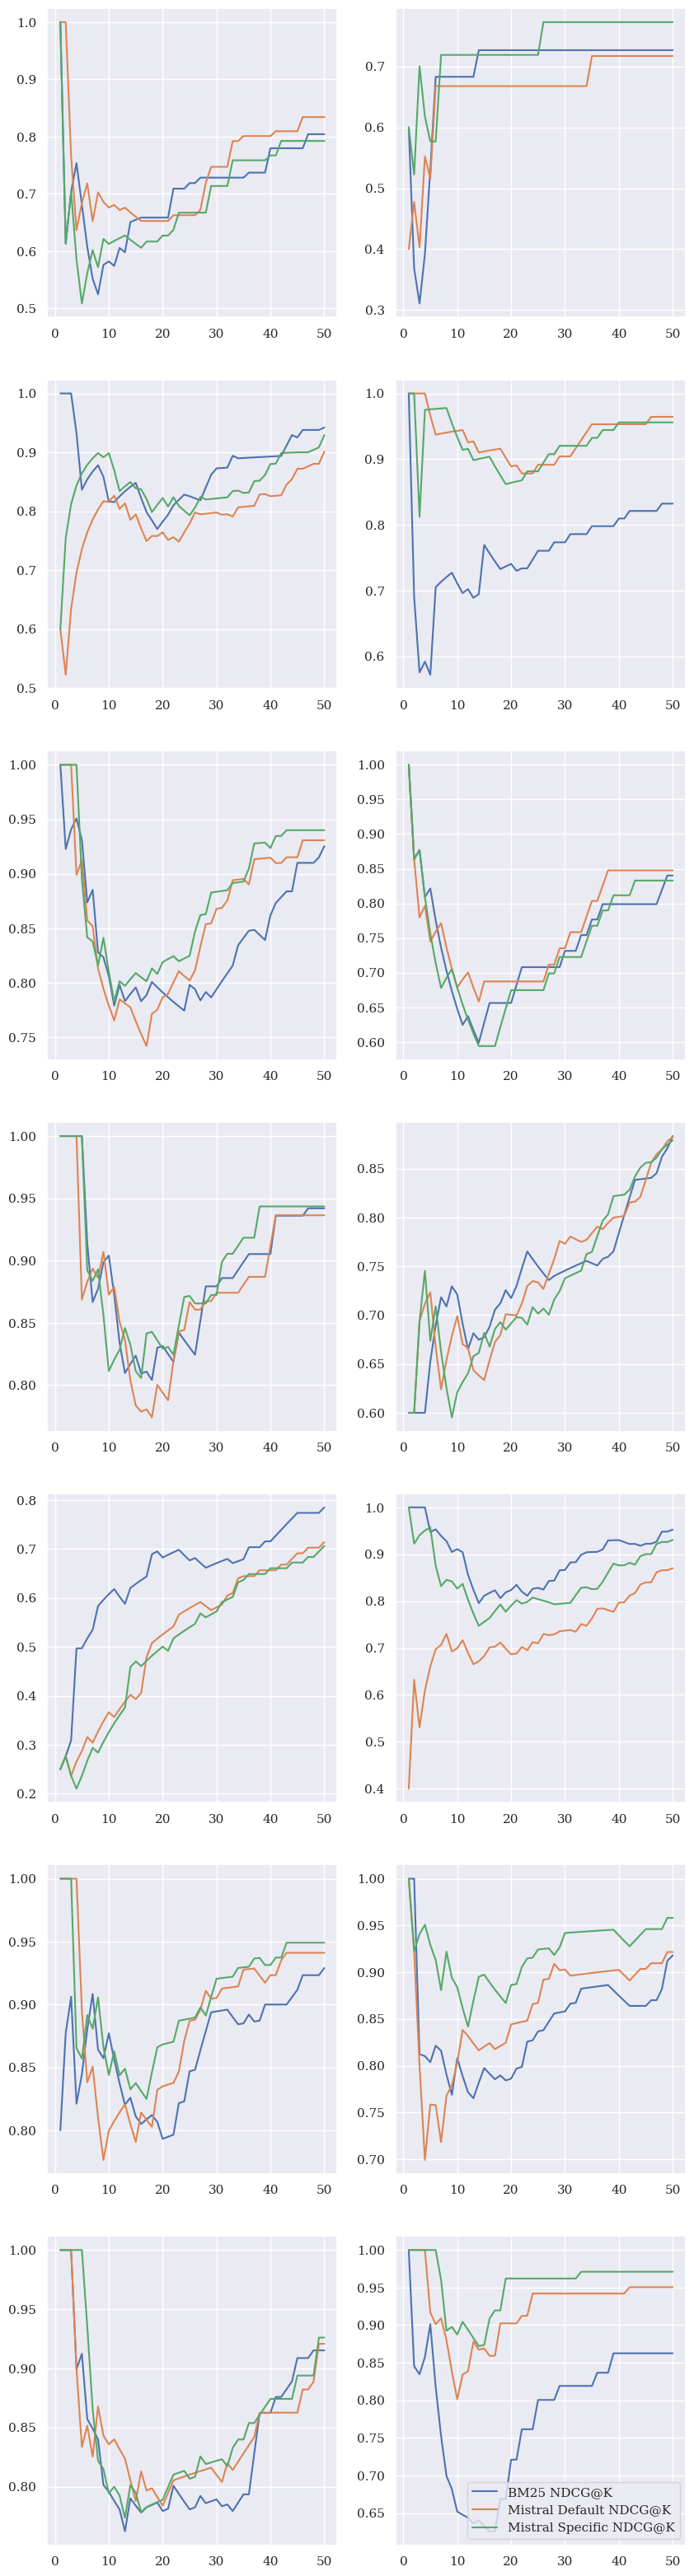

In [29]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (10, 40)
fig, axs = plt.subplots(7, 2)
for i in range(7):
    for j in range(2):
        df = pd.read_csv(filepaths_metrics[i * 2 + j])
        axs[i, j].plot(x, df['BM25 NDCG@K'], label = 'BM25 NDCG@K')
        axs[i, j].plot(x, df['e5-mistral-7b-instruct Default Instruct NDCG@K'], label = 'Mistral Default NDCG@K')
        axs[i, j].plot(x, df['e5-mistral-7b-instruct Specific Instruct NDCG@K'], label = 'Mistral Specific NDCG@K')
plt.legend()
plt.show()

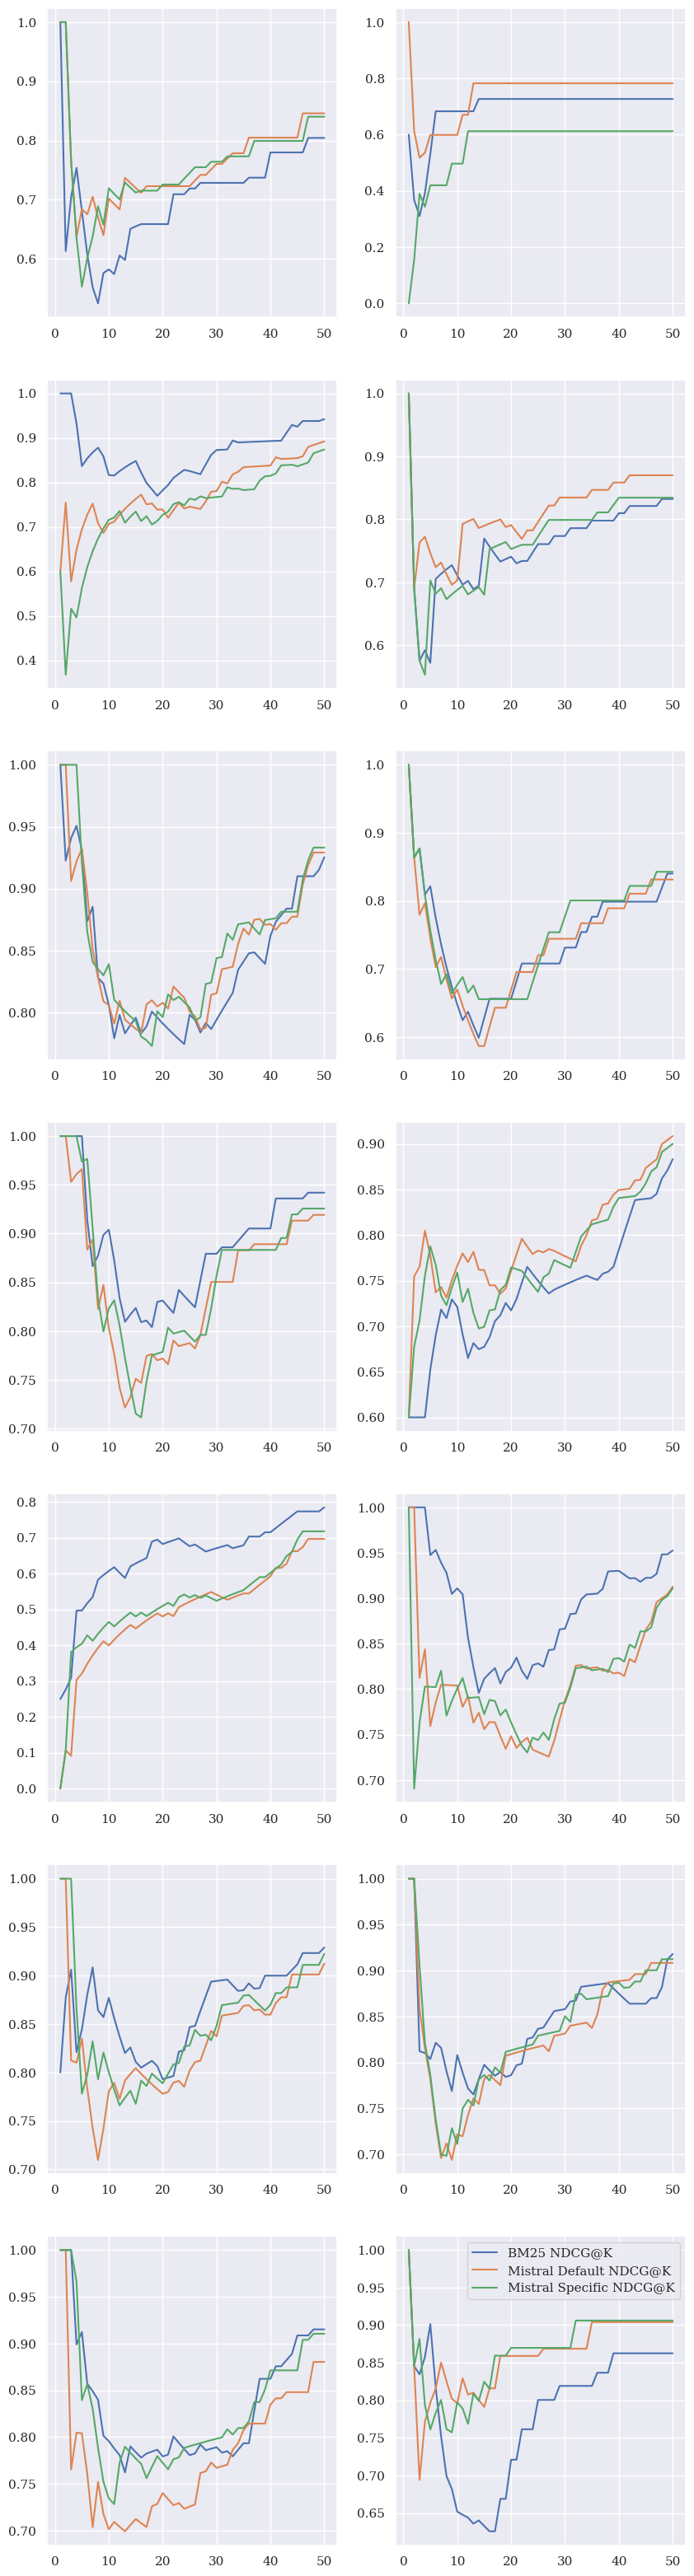

In [20]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (10, 40)
fig, axs = plt.subplots(7, 2)
for i in range(7):
    for j in range(2):
        df = pd.read_csv(filepaths_metrics[i * 2 + j])
        axs[i, j].plot(x, df['BM25 NDCG@K'], label = 'BM25 NDCG@K')
        axs[i, j].plot(x, df['GritLM-7B Default Instruct NDCG@K'], label = 'Mistral Default NDCG@K')
        axs[i, j].plot(x, df['GritLM-7B Specific Instruct NDCG@K'], label = 'Mistral Specific NDCG@K')
plt.legend()
plt.show()

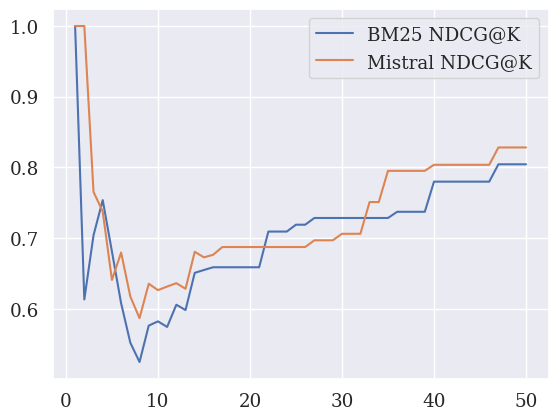

In [77]:
import matplotlib.pyplot as plt 
import numpy as np
  
# create data 
x = list(range(1, 51))
bm25_metric = df['BM25 NDCG@K']
mistral_metric = df['SFR-Embedding-Mistral Default Instruct NDCG@K']
  
# plot lines 
plt.plot(x, bm25_metric, label = "BM25 NDCG@K") 
plt.plot(x, mistral_metric, label = "Mistral NDCG@K") 
plt.legend() 
plt.show()

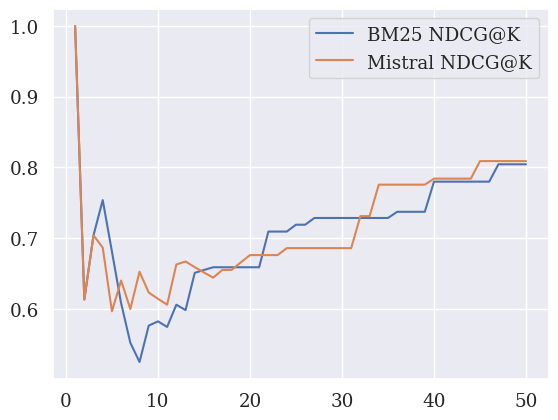

In [79]:
import matplotlib.pyplot as plt 
import numpy as np 
  
# create data 
x = list(range(1, 51))
bm25_metric = df['BM25 NDCG@K']
mistral_metric = ndcg(relevance_scores_mistral)
  
# plot lines 
plt.plot(x, bm25_metric, label = "BM25 NDCG@K") 
plt.plot(x, mistral_metric, label = "Mistral NDCG@K") 
plt.legend() 
plt.show()

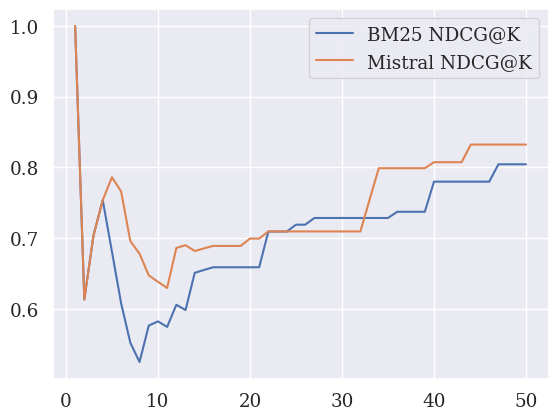

In [21]:
import matplotlib.pyplot as plt 
import numpy as np
  
# create data 
x = list(range(1, 51))
bm25_metric = df['BM25 NDCG@K']
mistral_metric = df['SFR-Embedding-Mistral Specific Instruct NDCG@K']
  
# plot lines 
plt.plot(x, bm25_metric, label = "BM25 NDCG@K") 
plt.plot(x, mistral_metric, label = "Mistral NDCG@K") 
plt.legend() 
plt.show()